In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.viz
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc import config
import dvu
dvu.set_style()

In [ ]:
pilot_name = 'pilot5_story_data.pkl'

stories_data_dict = joblib.load(
    join(config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot5_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20240604')

In [ ]:
# load responses
default_story_idxs = np.where(
    (np.array(stories_data_dict['story_setting']) == 'roi')
)[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in default_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

In [ ]:
mats = defaultdict(list)
use_clusters = False
voxel_resps_dict = defaultdict(list)
for story_num in default_story_idxs:
    rows = stories_data_dict["rows"][story_num]

    # get resp_chunks
    resp_story = resps_dict[
        stories_data_dict["story_name_new"][story_num].replace(
            '_resps', '')
    ].T  # (voxels, time)
    timing = stories_data_dict["timing"][story_num]
    if 'paragraphs' in stories_data_dict.keys():
        paragraphs = stories_data_dict["paragraphs"][story_num]
    else:
        paragraphs = stories_data_dict["story_text"][story_num].split(
            "\n\n")
    # paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
    if pilot_name in ['pilot3_story_data.pkl']:
        paragraphs = [sasc.analyze_helper.remove_repeated_words(
            p) for p in paragraphs]
    assert len(paragraphs) == len(
        rows), f"{len(paragraphs)} != {len(rows)}"
    resp_chunks = analyze_helper.get_resps_for_paragraphs(
        timing, paragraphs, resp_story, offset=2)
    assert len(resp_chunks) <= len(paragraphs)

    # calculate mat
    mat = np.zeros((len(rows), len(paragraphs)))
    # mat_dict = {}
    for i in range(len(resp_chunks)):
        mat[:, i] = [resp_chunks[i][x].mean()
                     for x in rows['voxel_nums']]
        voxel_resps_dict[rows['roi'].values[i]].append([resp_chunks[i][x]
                                                        for x in rows['voxel_nums']])
    mat[:, 0] = np.nan  # ignore the first column
    # print('mat', mat)

    # sort by voxel_num
    if 'voxel_num' in rows.columns:
        args = np.argsort(rows["voxel_num"].values)
    else:
        args = np.argsort(rows["roi"].values)
    mat = mat[args, :][:, args]
    mats[use_clusters].append(deepcopy(mat))

    # plt.imshow(mat)
    # plt.colorbar(label="Mean response")
    # plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
    # plt.ylabel("Voxel")
    # plt.show()

if 'voxel_num' in rows.columns:
    rows = rows.sort_values(by="voxel_num")
else:
    rows = rows.sort_values(by="roi")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(mats[use_clusters])  # (6, 17, 17)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

In [ ]:
voxel_resps_dict['sPMv'][0].shape

### Make average plot

In [ ]:
# calculate means
use_clusters = False
m1 = m[use_clusters]
diag_means = np.diag(m1)
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / len(diag_means))
sasc.viz.barplot_default([diag_means], [off_diag_means],
                         pilot_name, expls, annot_points=False)
joblib.dump({'diag_means': diag_means,
            'off_diag_means': off_diag_means}, join(config.RESULTS_DIR, 'processed', pilot_name.replace('_story_data.pkl', '_default_means.pkl')))

In [ ]:
for tup in rows[['roi', 'expl']].values:
    print(tup[0] + ': ', tup[1])

### Story-level differences

In [ ]:
def get_story_df(mats1, melt=False):
    d = defaultdict(list)
    story_names = resp_np_files
    for i in range(len(mats1)):
        m = mats1[i]
        d['driving'].append(np.nanmean(np.diag(m)))
        d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
        d['story'].append(story_names[i].replace('.npy', ''))
    d = pd.DataFrame.from_dict(d)
    if melt:
        d = d.melt(id_vars='story', value_vars=[
            'driving', 'baseline'], var_name='condition', value_name='mean')
        d = d[d.condition == 'driving']
    return d


use_clusters = False
mats1 = mats[use_clusters]
story_scores_df = get_story_df(mats1)
joblib.dump(story_scores_df, join(config.RESULTS_DIR, 'processed',
            pilot_name.replace('_story_data.pkl', '_default_story_scores.pkl')))

sasc.viz.stories_barplot(story_scores_df)

### ROI heatmap

In [ ]:
assert pilot_name == 'pilot5_story_data.pkl'
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)

s = 'small'
# expls_order = analyze_helper.sort_expls_semantically(expls, device='cuda')
rois = rows["roi"].values
expls_order = np.argsort(rois)
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]

rois = rois[expls_order]
sasc.viz.imshow_diverging(
    m_plot, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel("Driving paragraph",  # \n(Ideally, diagonal should be brighter)",
           fontsize='large')

# plt.ylabel("Voxel", fontsize='x-small')
# labs = expls[expls_order]

plt.ylabel("ROI response", fontsize='large')
# labs = [f'{i + 1:02d}' for i in range(len(expls_order))]
labs = expls[expls_order]
for i in range(len(labs)):
    print(labs[i], expls[expls_order[i]])

plt.yticks(labels=[x.replace('_only', '') for x in rois], ticks=np.arange(
    len(expls)), fontsize=s)
plt.xticks(labels=[x.replace('2', '').replace('_', '-') for x in rois], ticks=np.arange(
    len(expls)), rotation=90, fontsize=s)
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

### ROI heatmap truncated

<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_4075044/4127475463.py:26: DeprecationWarning: invalid escape sequence '\s'
  m_plot, clab="Mean response ($\sigma$)", clab_size='large')


[4 6 8]
Spatial positioning and directions Spatial positioning and directions
Unappetizing foods Unappetizing foods
Location names Location names


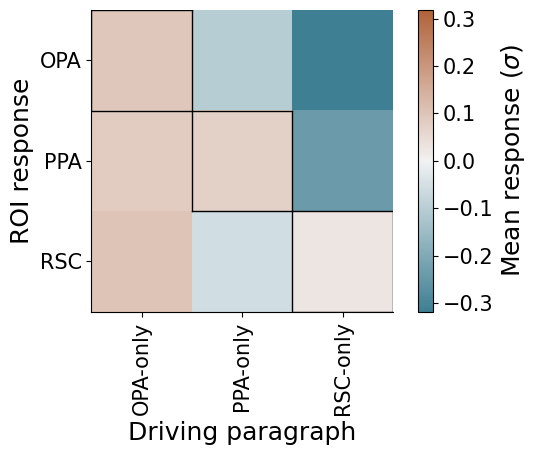

In [43]:
assert pilot_name == 'pilot5_story_data.pkl'
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)

s = 'medium'
# expls_order = analyze_helper.sort_expls_semantically(expls, device='cuda')
rois = rows["roi"].values
expls_order = np.argsort(rois)

# remove idxs where roi is not in ['OPA-only', 'RSC-only']
expls_order = expls_order[np.where(
    np.array([x in ['OPA_only', 'RSC_only', 'PPA_only2'] for x in rois[expls_order]]) == True)[0]]
print(expls_order)


m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]


rois = rois[expls_order]
sasc.viz.imshow_diverging(
    m_plot, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel("Driving paragraph",  # \n(Ideally, diagonal should be brighter)",
           fontsize='large')

# plt.ylabel("Voxel", fontsize='x-small')
# labs = expls[expls_order]

plt.ylabel("ROI response", fontsize='large')
# labs = [f'{i + 1:02d}' for i in range(len(expls_order))]
labs = expls[expls_order]
for i in range(len(labs)):
    print(labs[i], expls[expls_order[i]])

plt.yticks(labels=[x.replace('_only', '').replace('2', '') for x in rois], ticks=np.arange(
    len(rois)), fontsize=s)
plt.xticks(labels=[x.replace('2', '').replace('_', '-') for x in rois], ticks=np.arange(
    len(rois)), rotation=90, fontsize=s)
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
m_plot